<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Laboratory Task 2
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Contents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Data Preprocessing</a></li>
        <li><a href="#002">Data Collection</a></li>
    </ol>
</div>

In [1]:
# !pip install beautifulsoup4

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from __future__ import annotations
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import warnings
import urllib
import os

warnings.filterwarnings(action="ignore")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Data Preprocessing
        </p>
    </a>
</blockquote>

Collecting data for training and validation: film titles, posters, and short descriptions from imdb.com. First, let's download the official movie dataset from imdb.com: https://www.imdb.com/interfaces.

**title.basics.tsv.gz** сontains useful information:
- **tconst** (string) - alphanumeric unique identifier of the title
- **titleType** (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- **primaryTitle** (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- **startYear** (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- **genres** (string array) – includes up to three genres associated with the title

In [3]:
raw_data = pd.read_csv("imdb.tsv", sep="\t", low_memory=False)
print(f"Number of unique titles: {raw_data['tconst'].nunique()}")
raw_data.head()

Number of unique titles: 9372141


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Let's leave only the information that is important.

In [4]:
raw_data = raw_data[["tconst", "titleType", "primaryTitle", "startYear", "genres"]]
raw_data.head()

,tconst,titleType,primaryTitle,startYear,genres
0,tt0000001,short,Carmencita,1894,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,1892,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,1892,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,1892,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,1893,"Comedy,Short"


Let's leave only those lines that relate to films.

In [ ]:
raw_data = raw_data[raw_data["titleType"] == "movie"]
print(f"Number of unique titles: {raw_data['tconst'].nunique()}")
raw_data.head()

There is too much data and not all films are relevant for predicting the genres of modern cinema. Let's leave only films made from 2010 to 2020 for the training and test sets, and from 2020 to the present for the validation set.

First, let's remove the missing values. In the set they are listed as "\N".

In [6]:
for column in raw_data:
    raw_data = raw_data[raw_data[column] != r"\N"]

raw_data.reset_index(drop=True, inplace=True)
print(f"Number of unique titles: {raw_data['tconst'].nunique()}")
raw_data.head()

Number of unique titles: 474719


,tconst,titleType,primaryTitle,startYear,genres
0,tt0000009,movie,Miss Jerry,1894,Romance
1,tt0000574,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography"
2,tt0000591,movie,The Prodigal Son,1907,Drama
3,tt0000615,movie,Robbery Under Arms,1907,Drama
4,tt0000630,movie,Hamlet,1908,Drama


In [7]:
raw_data["startYear"] = pd.to_numeric(raw_data["startYear"], errors="coerce")
train_data = raw_data[(raw_data["startYear"] >= 2010) & (raw_data["startYear"] <= 2020)]

print(f"Number of unique titles: {train_data['tconst'].nunique()}")
train_data.reset_index(drop=True, inplace=True)
train_data.head()

Number of unique titles: 170663


,tconst,titleType,primaryTitle,startYear,genres
0,tt0011801,movie,Tötet nicht mehr,2019,"Action,Crime"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,Drama
2,tt0069049,movie,The Other Side of the Wind,2018,Drama
3,tt0083060,movie,The Drive to Win,2019,"Drama,Sport"
4,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"


Let's remove non-English movie titles.

In [8]:
def filter_titles(title: str) -> str | None:
    if title.isascii():
        return title

train_data["primaryTitle"] = train_data["primaryTitle"].apply(filter_titles)
train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)

print(f"Number of unique titles: {train_data['tconst'].nunique()}")
train_data.head()

Number of unique titles: 161492


,tconst,titleType,primaryTitle,startYear,genres
0,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,Drama
1,tt0069049,movie,The Other Side of the Wind,2018,Drama
2,tt0083060,movie,The Drive to Win,2019,"Drama,Sport"
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"
4,tt0104278,movie,Flaming Ears,2013,"Fantasy,Sci-Fi"


<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Data Collection
        </p>
    </a>
</blockquote>

In [9]:
labels = [
    "Romance", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary",
    "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Superhero",
    "Musical", "Mystery", "Sci-Fi", "Sport", "Thriller", "War", "Western", "Short"
]

In [10]:
root = "imdb_dataset"

def create_directory(root: str, labels: str) -> None:
    os.makedirs(root) if not os.path.exists(root) else 0
    [os.makedirs(os.path.join(root, label)) for label in labels if not os.path.exists(os.path.join(root, label))]

create_directory(root=root, labels=labels)

```
imdb_dataset/
            |
            Romance/
            |      |
            |      0.jpg
            |      ...
            Action/
            ...
```

In [11]:
train_data["used"] = 0
cleaned_data = pd.DataFrame(columns=["id", "title", "synopsis", "poster_url", "poster_path", "genre"])

In [12]:
idx = 0
domain = "https://www.imdb.com/title/"

for label in tqdm(labels):
    n = 0
    # Films should not be repeated in different genres.
    train_data = train_data[train_data["used"] == 0]
    train_data.reset_index(drop=True, inplace=True)
    
    for row in range(len(train_data)):
        if label in train_data.loc[row, "genres"].split(","):
            try:
                search_url = domain + train_data.loc[row, "tconst"] + "/"
                with urllib.request.urlopen(search_url) as response:
                    html = response.read()
                    soup = BeautifulSoup(html, "html.parser")
                
                synopsis = soup.find("meta", property="og:description")["content"].split(": ")[1]
                image_url = soup.find("meta", property="og:image")["content"]
                urllib.request.urlretrieve(image_url, os.path.join(root, label, "{}.jpg".format(n)))
                
                cleaned_data.loc[idx, "id"] = train_data.loc[row, "tconst"]
                cleaned_data.loc[idx, "title"] = train_data.loc[row, "primaryTitle"]
                cleaned_data.loc[idx, "synopsis"] = synopsis
                cleaned_data.loc[idx, "poster_url"] = image_url
                cleaned_data.loc[idx, "poster_path"] = os.path.join(root, label, "{}.jpg".format(n))
                cleaned_data.loc[idx, "genre"] = label
                train_data.loc[row, "used"] = 1
                n = n + 1
                idx = idx + 1
            except:
                pass
            
            print("{}: {}/300".format(label, n), end="\r")
            if n == 300:
                print("{}: {}/300".format(label, n))
                break

  0%|          | 0/24 [00:00<?, ?it/s]

Romance: 300/300
Action: 300/300
Adventure: 300/300
Animation: 300/300
Biography: 300/300
Comedy: 300/300
Crime: 300/300
Documentary: 300/300
Drama: 300/300
Family: 300/300
Fantasy: 300/300
History: 300/300
Horror: 300/300
Music: 300/300
Musical: 300/300
Mystery: 300/300
Sci-Fi: 300/300
Sport: 300/300
Thriller: 300/300
War: 300/300
Western: 300/300


In [13]:
cleaned_data.to_csv("cleaned_data.csv", index=False)
train_data.to_csv("train_data.csv", index=False)

Some manipulations to collect the missing data.

In [5]:
raw_data = raw_data[raw_data["titleType"] == "short"]

for column in raw_data:
    raw_data = raw_data[raw_data[column] != r"\N"]

raw_data["startYear"] = pd.to_numeric(raw_data["startYear"], errors="coerce")
train_data = raw_data[(raw_data["startYear"] >= 2010) & (raw_data["startYear"] <= 2020)]

def filter_titles(title: str) -> str | None:
    if title.isascii():
        return title

train_data["primaryTitle"] = train_data["primaryTitle"].apply(filter_titles)
train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)

print(f"Number of unique titles: {train_data['tconst'].nunique()}")
train_data.head()

Number of unique titles: 462974


,tconst,titleType,primaryTitle,startYear,genres
0,tt0060366,short,A Embalagem de Vidro,2020,"Documentary,Short"
1,tt0065047,short,The Sun's Gonna Shine,2014,"Documentary,Music,Short"
2,tt0089435,short,Kokoa,2019,"Animation,Short"
3,tt0108270,short,Symphony 92.4 FM,2013,Short
4,tt0110152,short,The History of the World Episode 16 the Invent...,2016,Short


In [6]:
cleaned_data = pd.read_csv("cleaned_data.csv")
print(f"Size of dataset: {len(cleaned_data)}")
cleaned_data.head()

Size of dataset: 6331


,id,title,synopsis,poster_url,poster_path,genre
0,tt0311448,Lives No Longer Ours,Directed by Paul Sanderson. With Paul Sanderso...,https://m.media-amazon.com/images/M/MV5BZGQxMD...,imdb_dataset\Romance\0.jpg,Romance
1,tt0337692,On the Road,"Directed by Walter Salles. With Sam Riley, Gar...",https://m.media-amazon.com/images/M/MV5BMTc1Mz...,imdb_dataset\Romance\1.jpg,Romance
2,tt0365545,Nappily Ever After,Directed by Haifaa Al-Mansour. With Sanaa Lath...,https://m.media-amazon.com/images/M/MV5BMzIzMW...,imdb_dataset\Romance\2.jpg,Romance
3,tt0393049,Anderson's Cross,Directed by Jerome Elston Scott. With Michael ...,https://m.media-amazon.com/images/M/MV5BOTcwOT...,imdb_dataset\Romance\3.jpg,Romance
4,tt0435651,The Giver,"Directed by Phillip Noyce. With Jeff Bridges, ...",https://m.media-amazon.com/images/M/MV5BMTY1MT...,imdb_dataset\Romance\4.jpg,Romance


In [7]:
root = "imdb_dataset"
train_data["used"] = 0
labels = ["Short"]

idx = 6331
domain = "https://www.imdb.com/title/"

for label in tqdm(labels):
    n = 31
    # Films should not be repeated in different genres.
    train_data = train_data[train_data["used"] == 0]
    train_data.reset_index(drop=True, inplace=True)
    
    for row in range(len(train_data)):
        if label in train_data.loc[row, "genres"].split(","):
            try:
                search_url = domain + train_data.loc[row, "tconst"] + "/"
                with urllib.request.urlopen(search_url) as response:
                    html = response.read()
                    soup = BeautifulSoup(html, "html.parser")
                
                synopsis = soup.find("meta", property="og:description")["content"].split(": ")[1]
                image_url = soup.find("meta", property="og:image")["content"]
                urllib.request.urlretrieve(image_url, os.path.join(root, label, "{}.jpg".format(n)))
                
                cleaned_data.loc[idx, "id"] = train_data.loc[row, "tconst"]
                cleaned_data.loc[idx, "title"] = train_data.loc[row, "primaryTitle"]
                cleaned_data.loc[idx, "synopsis"] = synopsis
                cleaned_data.loc[idx, "poster_url"] = image_url
                cleaned_data.loc[idx, "poster_path"] = os.path.join(root, label, "{}.jpg".format(n))
                cleaned_data.loc[idx, "genre"] = label
                train_data.loc[row, "used"] = 1
                n = n + 1
                idx = idx + 1
            except:
                pass
            
            print("{}: {}/300".format(label, n), end="\r")
            if n == 300:
                print("{}: {}/300".format(label, n))
                break

  0%|          | 0/1 [00:00<?, ?it/s]

Short: 300/300


Size of dataset: 6600
Size of dataset: 5898


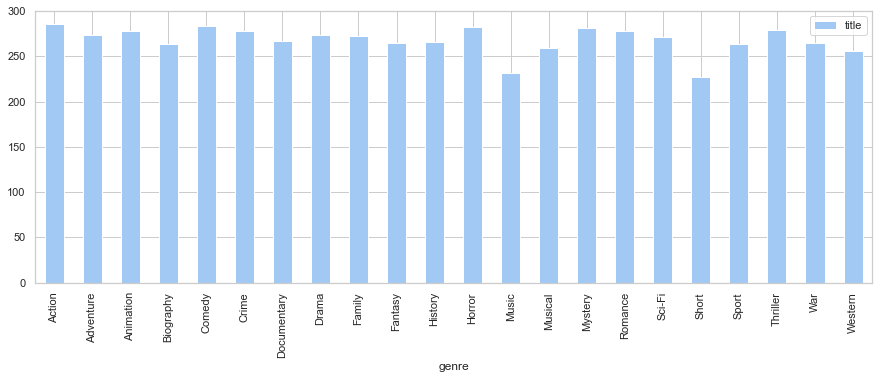

In [10]:
print(f"Size of dataset: {len(cleaned_data)}")
cleaned_data.drop_duplicates(subset=["poster_url"], keep=False, inplace=True)
cleaned_data.reset_index(drop=True, inplace=True)
print(f"Size of dataset: {len(cleaned_data)}")
cleaned_data.pivot_table(index="genre", values="title", aggfunc="count").plot(kind="bar", figsize=(15, 5))
plt.show()

In [12]:
cleaned_data.groupby(by="genre")["title"].count()

genre
Action         286
Adventure      273
Animation      278
Biography      264
Comedy         283
Crime          278
Documentary    267
Drama          273
Family         272
Fantasy        265
History        266
Horror         282
Music          231
Musical        259
Mystery        281
Romance        278
Sci-Fi         271
Short          227
Sport          264
Thriller       279
War            265
Western        256
Name: title, dtype: int64

In [13]:
train_data = pd.read_csv("train_data.csv")
root = "imdb_dataset"
labels = ["Superhero"]

idx = 5898
domain = "https://www.imdb.com/title/"

for label in tqdm(labels):
    n = 0
    # Films should not be repeated in different genres.
    train_data = train_data[train_data["used"] == 0]
    train_data.reset_index(drop=True, inplace=True)
    
    for row in range(len(train_data)):
        if "Fantasy" in train_data.loc[row, "genres"].split(",") and "Action" in train_data.loc[row, "genres"].split(","):
            try:
                search_url = domain + train_data.loc[row, "tconst"] + "/"
                with urllib.request.urlopen(search_url) as response:
                    html = response.read()
                    soup = BeautifulSoup(html, "html.parser")
                
                synopsis = soup.find("meta", property="og:description")["content"].split(": ")[1]
                image_url = soup.find("meta", property="og:image")["content"]
                urllib.request.urlretrieve(image_url, os.path.join(root, label, "{}.jpg".format(n)))
                
                cleaned_data.loc[idx, "id"] = train_data.loc[row, "tconst"]
                cleaned_data.loc[idx, "title"] = train_data.loc[row, "primaryTitle"]
                cleaned_data.loc[idx, "synopsis"] = synopsis
                cleaned_data.loc[idx, "poster_url"] = image_url
                cleaned_data.loc[idx, "poster_path"] = os.path.join(root, label, "{}.jpg".format(n))
                cleaned_data.loc[idx, "genre"] = label
                train_data.loc[row, "used"] = 1
                n = n + 1
                idx = idx + 1
            except:
                pass
            
            print("{}: {}/300".format(label, n), end="\r")
            if n == 300:
                print("{}: {}/300".format(label, n))
                break

  0%|          | 0/1 [00:00<?, ?it/s]

Superhero: 300/300


In [14]:
raw_data = pd.read_csv("imdb.tsv", sep="\t", low_memory=False)
raw_data = raw_data[["tconst", "titleType", "primaryTitle", "startYear", "genres"]]
raw_data = raw_data[raw_data["titleType"] == "movie"]

for column in raw_data:
    raw_data = raw_data[raw_data[column] != r"\N"]

raw_data["startYear"] = pd.to_numeric(raw_data["startYear"], errors="coerce")
train_data = raw_data[raw_data["startYear"] < 2010]
train_data.reset_index(drop=True, inplace=True)

In [15]:
root = "imdb_dataset"
train_data["used"] = 0
labels = ["Film-Noir"]

domain = "https://www.imdb.com/title/"

for label in tqdm(labels):
    n = 0
    # Films should not be repeated in different genres.
    train_data = train_data[train_data["used"] == 0]
    train_data.reset_index(drop=True, inplace=True)
    
    for row in range(len(train_data)):
        if label in train_data.loc[row, "genres"].split(","):
            try:
                search_url = domain + train_data.loc[row, "tconst"] + "/"
                with urllib.request.urlopen(search_url) as response:
                    html = response.read()
                    soup = BeautifulSoup(html, "html.parser")
                
                synopsis = soup.find("meta", property="og:description")["content"].split(": ")[1]
                image_url = soup.find("meta", property="og:image")["content"]
                urllib.request.urlretrieve(image_url, os.path.join(root, label, "{}.jpg".format(n)))
                
                cleaned_data.loc[idx, "id"] = train_data.loc[row, "tconst"]
                cleaned_data.loc[idx, "title"] = train_data.loc[row, "primaryTitle"]
                cleaned_data.loc[idx, "synopsis"] = synopsis
                cleaned_data.loc[idx, "poster_url"] = image_url
                cleaned_data.loc[idx, "poster_path"] = os.path.join(root, label, "{}.jpg".format(n))
                cleaned_data.loc[idx, "genre"] = label
                train_data.loc[row, "used"] = 1
                n = n + 1
                idx = idx + 1
            except:
                pass
            
            print("{}: {}/300".format(label, n), end="\r")
            if n == 300:
                print("{}: {}/300".format(label, n))
                break

  0%|          | 0/1 [00:00<?, ?it/s]

Film-Noir: 300/300


In [16]:
cleaned_data.drop_duplicates(subset=["poster_url"], keep=False, inplace=True)
cleaned_data.reset_index(drop=True, inplace=True)
cleaned_data.groupby(by="genre")["title"].count()

genre
Action         286
Adventure      273
Animation      278
Biography      264
Comedy         283
Crime          278
Documentary    267
Drama          273
Family         272
Fantasy        265
Film-Noir      299
History        266
Horror         282
Music          231
Musical        259
Mystery        281
Romance        278
Sci-Fi         271
Short          227
Sport          264
Superhero      283
Thriller       279
War            265
Western        256
Name: title, dtype: int64

Size of dataset: 6480


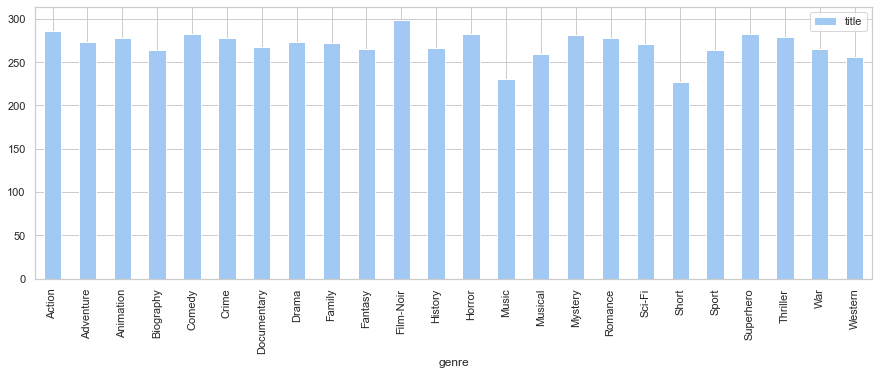

In [17]:
print(f"Size of dataset: {len(cleaned_data)}")
cleaned_data.pivot_table(index="genre", values="title", aggfunc="count").plot(kind="bar", figsize=(15, 5))
plt.show()

In [18]:
cleaned_data.to_csv("cleaned_data.csv", index=False)